# Introduction

La prédiction de séries temporelles est un sujet vaste et complexe, car il existe de nombreuses techniques, modèles et librairies pour la réaliser. On va donc commencer par dégager quelques clés de lectures.

## Comprendre l'objectif

Prédire un processus peut signigifier deux choses:
- Prédire une étape supplémentaire
- prédire plusieurs étapes supplémentaires

Si on prédit plusieurs étapes alors, on peut s'y prendre de deux manières:
- prédire toutes les étapes à l'aide de l'état initial
- prédire les étapes de manière itérative en utilisant nos prédictions des états intermédaires.

Predicting a process can mean two things:
- Predicting one additional step
- predicting several additional steps

If we predict several steps then we can do it in two ways:
- predict all steps using the initial state
- predict the steps in an iterative way using our predictions of the intermediate states.

## Comprendre les features

Pour prédire une série temporelle, on utilise trois types de features:
- **`Des indicateurs temporelles`**: l'année, le mois, le jour de la semaine, l'heure.
  - Par exemple si on prédit des ventes on va utiliser la valeur moyenne des ventes le lundi en octobre (saisonalité) et la tendance représentée par l'année
- **`Les états précédents du processus`** (ou lag en anglais)
- **`Les états précédents d'autre processus`**: on parle alors de processus multi-varié
  - On va considérer que la température dépend de la force du vent et donc ce servir de cette variable pour la prédire
  - Attention contrairement au cas classique, si je veux prédire la température à la date t, je ne connais pas la valeur de la force du vent à la date t. Utiliser d'autres processus est donc complexe car cela demande de les modéliser également pour prédire leurs états futurs. 

To predict a time series, we use three types of features:
- Temporal indicators**: the year, the month, the day of the week, the hour.
  - For example, if we predict sales, we will use the average value of sales on Monday in October (seasonality) and the trend represented by the year
- The previous states of the process** (or lag)
- The previous states of other processes**: we speak then of a multi-varied process
  - We will consider that the temperature depends on the wind strength and thus use this variable to predict it
  - Be careful, contrary to the classical case, if I want to predict the temperature at date t, I don't know the value of the wind force at date t. Using other processes is therefore complex because it requires to model them also to predict their future states. 


## Comprendre l'approche

Pour se repérer dans la foule des modèles disponibles, il faut comprendre à quel type d'approche ils appartiennent:
- **`L'approche statistique classique`**: L'objectif est de réaliser une modélisation lisible, on privilégie donc des modèles linéaires ou exponentiels
- **`L'approche machine learning`**: on ne cherche pas à modéliser de manière lisible mais simplement à obtenir une prédiction de bonne qualité. On va utiliser un Xgboost classique, la différence viendra de la construction de la BDD
- **`L'approche deep learning`**: encore une boite noire, on va ici essayer de tirer partie des convonlutions et des réseaux de neurones récurrents.

In order to find one's way through the crowd of available models, one must understand to which type of approach they belong:
- The classical statistical approach**: the objective is to model in a readable way, so linear or exponential models are preferred
- The machine learning approach: we do not try to model in a readable way but simply to obtain a good quality prediction. We will use a classical Xgboost, the difference will come from the construction of the DB
- The deep learning approach: again a black box, we will try to take advantage of convonlutions and recurrent neural networks.



# La méthode classique

## La théorie

Encore une fois il y a pas mal de vocabulaire sur les séries temporelles, ou "processus".

- **`Processus univarié`**: On s'intéresse simplement à l'évolution d'une variable ou **`Multi-varié`**: plusieurs variables évoluent au cous du temps et s'infuencent.
- **`Autocorrélation`**: corrélation entre deux horizons temporels d'un série (exemple entre Xt et Xt-1)
- **`Bruit blanc`**: suite à une modélisation, un signal résiduel qui ne contient plus d'information temporelle
- **`Processus Stationnaire`**: Un processus est (faiblement) stationnaire si son espérance et ses autocovariances sont invariantes par translation dans le temps. En français, peu importe quand on le regarde, il tourne toujours autour de la même moyenne avec des variations similaires (donc pas de saisonalité et pas de tendance)
- **`Processus Auto-regressif (d'ordre p)`** (AR): Si chaque point d'un processus peut être modélisé par une relation linéaire entre lui et les p points qui le précèdent
- **`Processus Moving Average (s'ordre q)`** (MA): Si un processus peut être considéré comme la résultante d'une combinaison linéaire de perturbations decorrélées (un bruit blanc et son passé).
- **`Processus ARMA`**: c'est un processus stationnaire dont chaque point est la combinaison d'une relation linéaire entre les points précédents et une relation linéaire entre bruits blancs.
- **`Processus ARIMA`** (integrated): Les modèles ARIMA permettent de modéliser des séries temporelles qui présentent une tendance polynomiale.
- **`Processus SARIMA`** (seasonal): Les modèles SARIMA permettent de modéliser des séries qui présentent une saisonnalité. 

Once again there is a lot of vocabulary about time series, or "processes".

- Univariate process": We are simply interested in the evolution of one variable or "Multivariate": several variables evolve over time and influence each other.
- Autocorrelation": correlation between two time horizons of a series (example between Xt and Xt-1)
- White noise": following a modeling, a residual signal that no longer contains temporal information
- Stationary process": A process is (weakly) stationary if its expectation and its autocovariances are invariant by translation in time. In other words, no matter when we look at it, it always revolves around the same mean with similar variations (thus no seasonality and no trend)
- Auto-regressive process (of order p)`** (AR): If each point of a process can be modeled by a linear relationship between it and the p points preceding it
- Moving Average Process (of order q)`** (MA): If a process can be considered as the result of a linear combination of decorrelated disturbances (a white noise and its past).
- ARMA process**: it is a stationary process where each point is the combination of a linear relation between the previous points and a linear relation between white noise.
- ARIMA process** (integrated): ARIMA models are used to model time series that exhibit a polynomial trend.
- SARIMA process** (seasonal): SARIMA models are used to model time series that exhibit seasonality. 

![processus](https://www.machinelearningplus.com/wp-content/uploads/2019/02/stationary-and-non-stationary-time-series.png)

Pourquoi est ce qu'on s'interesse à la stationnarité?

Nous l'avons dit, le principe de l'approche classique est de rendre une série temporelle lisible. Or le modèle le plus lisible est la régression linéaire. On sait que la régression linéaire a ue hypothèse forte, celle de l'indépendance entre ses varaibles explicatives. Ici les variables explicatives sont états précédents (lags: Xt-1, Xt-2...). On veut donc les rendre independants (supprimer l'auto-correlation) pour avoir une régression linéaire qui marche. Supprimer l'autocorrélation, cela revient à rendre un processus stationnaire. 

Why are we interested in stationarity?

As we said, the principle of the classical approach is to make a time series readable. The most readable model is linear regression. We know that linear regression has a strong hypothesis, that of independence between its explanatory variables. Here the explanatory variables are previous states (lags: Xt-1, Xt-2...). We want to make them independent (remove the autocorrelation) to have a linear regression that works. Removing the autocorrelation is the same as making a process stationary. 

En résumé, modéliser un processus univarié consiste à:
1. Déterminer si le processus est stationnaire
2. Si non, rendre le processus stationnaire
   - Trouver le polynome qui permet de supprimer la tendance
   - Trouver les saisonnalités
   - Si ça ne suffit pas, utiliser des algorithmes permettant de stationnairiser le processus
3. Trouver les paramètres q et p permettant de modéliser le processus ARMA résultant 

In summary, modeling a univariate process consists of:
1. Determine if the process is stationary
2. If not, make the process stationary
   - Find the polynomial that allows to remove the trend
   - Find the seasonality
   - If this is not enough, use algorithms to make the process stationary
3. Find the parameters q and p to model the resulting ARMA process 

# La pratique

Pour l'approche statistique on va utiliser le package statmodele.
Statmodèle est un package de statistique plus que de machine learning. Son optique n'est pas la prédiction mais la modélisation. Il correspond donc parfaitement à cette première approche.
On va l'utiliser en le combinant avec pmdarima qui permet d'automatiser certaines tâches complexes et chronophages. 

For the statistical approach we will use the package statmodele.
Statmodele is a statistical package more than a machine learning package. Its purpose is not prediction but modeling. It corresponds perfectly to this first approach.
We will use it in combination with pmdarima which allows to automate some complex and time consuming tasks. 

## Le modèle ARIMA

Le modèle ARIMA dépend de 3 hyper-paramètres:
- p nombre de lags utilisés comme variables explicatives.
- q nombre de bruits blancs utiles (erreurs de prédictions)
- d nombre de différenciation utiles pour rendre le processus stationnaire. 

La différenciation est la technique la plus classique pour stationnariser un processus, on soustrait à Xt , Xt-1. parfois il faut soustraire plus de lags.

The ARIMA model depends on 3 hyper-parameters:
- p number of lags used as explanatory variables.
- q number of useful white noise (prediction errors)
- d number of differentiations useful to make the process stationary. 

Differentiation is the most classical technique to make a process stationary, we subtract from Xt , Xt-1. Sometimes we have to subtract more lags.

Ces trois paramètres peuvent être recherchés independement par des approches graphiques ou statistiques (tests-statistiques). Statmodel propose tous les outils nécessaires, une mise en oeuvre peut être retrouvée [ici](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#arimapythonnotebook) 

Nous allons laisser pmdarima le faire pour nous cependant

These three parameters can be searched independently by graphical or statistical approaches (test-statistics). Statmodel offers all the necessary tools, an implementation can be found [here](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#arimapythonnotebook) 

We will let pmdarima do it for us though

In [2]:
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

Pour savoir si la série est stationnaire on va utiliser le test de Dicker Fuller augmenté (adf). Son hypothèse nulle est que le processus n'est pas stationnaire. Si la p-value est inférieure à 0.05 on va donc rejeter cette hypothèse et considérer que le processus est stationaire.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   100 non-null    int64
dtypes: int64(1)
memory usage: 928.0 bytes


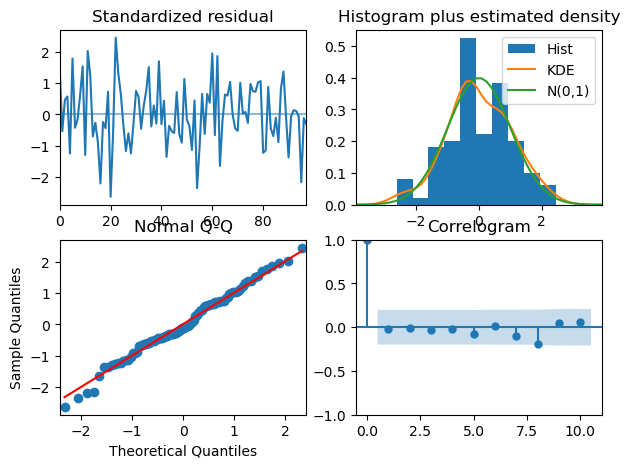

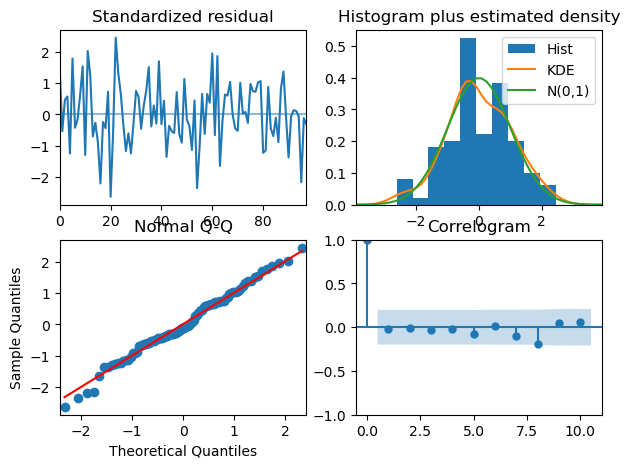

In [4]:
import matplotlib as plt

model.plot_diagnostics(figsize=(7,5))
# plt.show()

### 1. Evaluer la saisonnalité 

In [5]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller


# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Ici la p-value est supérieure à 0.05, on ne peut donc pas rejeter l'hypothèse nulle (on ne l'accepte pas statistiquement pour autant mais on va quand même essayer de la rendre stationnaire)

### Désaisonnaliser une série temporelle

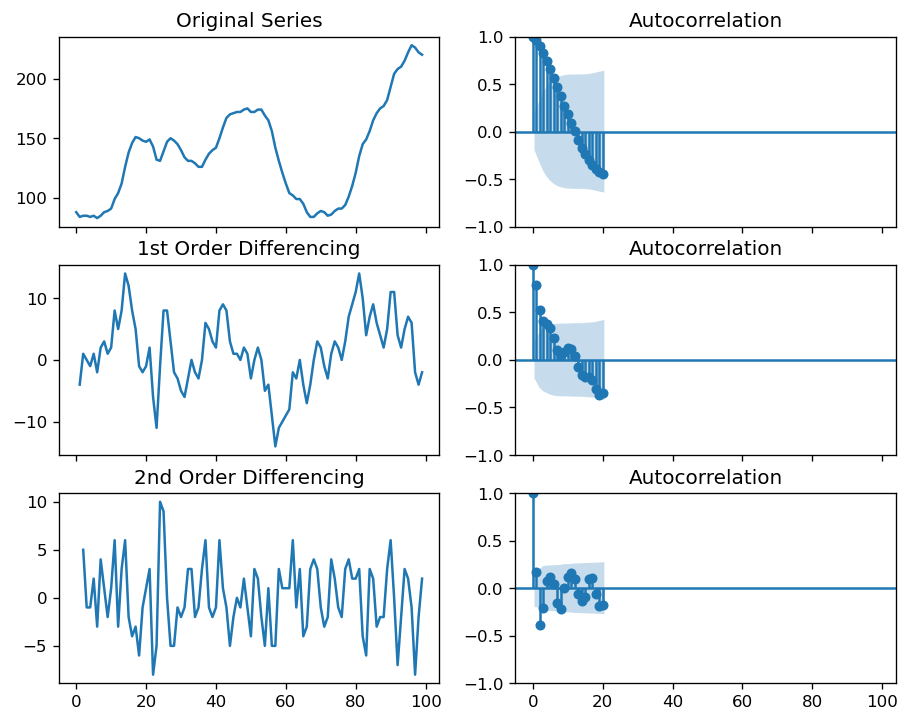

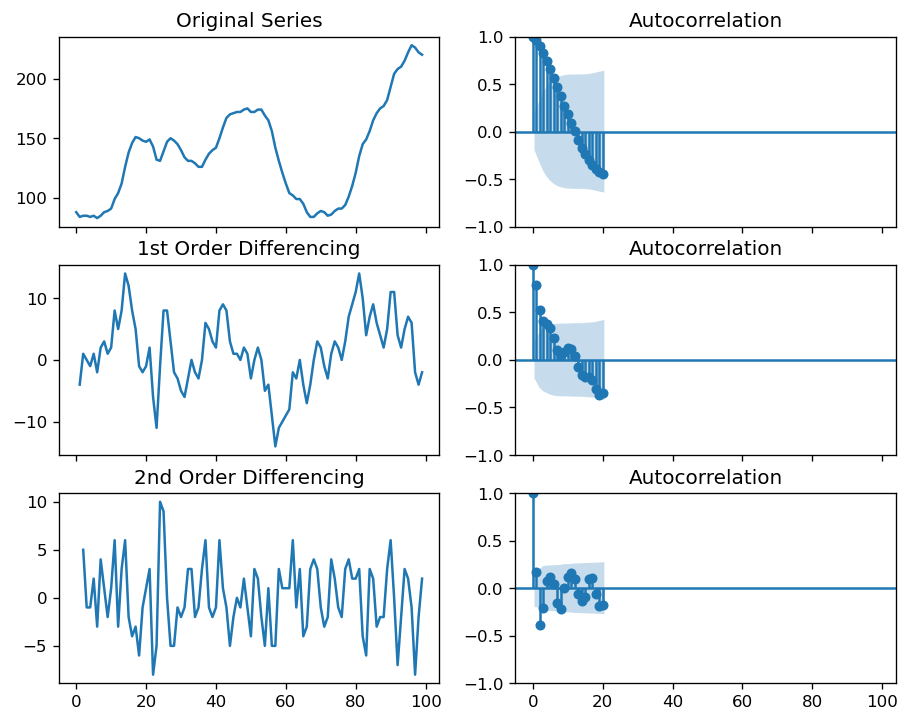

In [6]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])


c:\Users\Apprenant\anaconda3\envs\timeseries\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


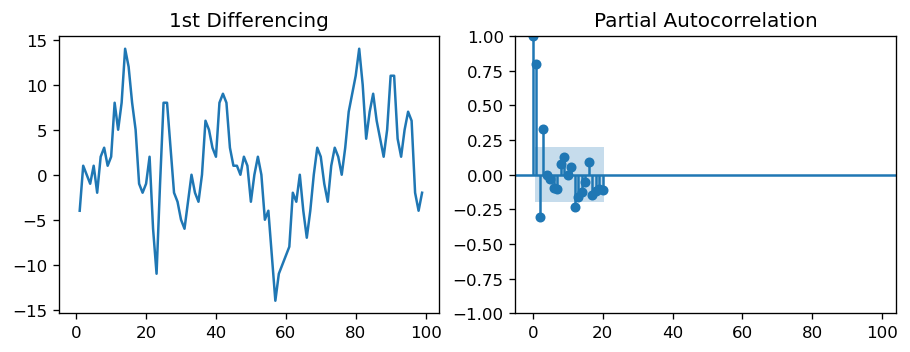

In [7]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

# axes[0].plot(df_input.item_lost); axes[0].set_title('Original')
# axes[1].set(ylim=(0,5))
# plot_pacf(df_input.item_lost.dropna(), ax=axes[1])

plt.show()

# Interpolate

On a le choix entre mettree en place ces méthodes en utilisant statmodel (approche plus statistique) ou pmdarima (plus automatique)

Le lissage exponentiel double 


La méthode de Holt-Winters


Les modèles ARMAX
Ils permettent d'incorporer des variables exogènes aux modèles ARMA. Notons qu'en cas de relation complexe avec des covariables autres que le passé du processus, il est souvent plus aisé de considérer un modèle de régression (adapté aux données temporellement dépendantes).

Les modèles ARCH et GARCH
ARCH (introduits par Engle en 1982) et GARCH (introduits par Bollerslev en 1986) sont des extensions des modèles AR qui permettent de tenir compte la \og volatilité stochastique\fg{} de séries temporelles. Ces techniques sont particulièrement utiles dans le domaine de la finance.

Les modèles à mémoire longue
Les modèles ARMA sont dits à mémoire courte : deux instants éloignés du processus n'ont que très peu d'interaction entre eux. Il existe d'autres modélisations pour les processus à mémoire longue, tels que les FARIMA (introduits par Granger en 1980).

Les modèles multivariés
On est parfois amenés à modéliser simultanément plusieurs séries ayant de fortes relations entre elles. On considère alors des modèles VAR, VEC, espace-état (et le filtrage de Kalman) etc., ainsi que des notions telles que la causalité au sens de Granger, la cointégration, etc.

D'autres alternatives
Il existe de nombreux autres modèles (paramétriques) non linéaires tels que les modèles à seuil.

Au delà des solutions paramétriques, on trouve également des modèles non et semi paramétriques, ces derniers permettant de pallier le "fléau de la dimension" du non-paramétrique. Citons les méthodes de noyau, la décomposition en ondelettes, les modèles GAM, etc.

Ressources
time serie analysis: https://www.machinelearningplus.com/time-series/time-series-analysis-python/
ARIMA : https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
